### Add primary imports

In [1]:
from matplotlib import pyplot
from keras.datasets import mnist
import numpy as np
from tensorflow.keras.utils import to_categorical, plot_model
import math
from sklearn.metrics import accuracy_score

### Load data 

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()



batch_size = 1000
batch_sample = int(batch_size/10)

x_train = x_train[:batch_size]
y_train = y_train[:batch_size]
x_test = x_test[:batch_sample]
y_test = y_test[:batch_sample]


print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (1000, 28, 28)
Y_train: (1000,)
X_test:  (100, 28, 28)
Y_test:  (100,)


### Plotting data

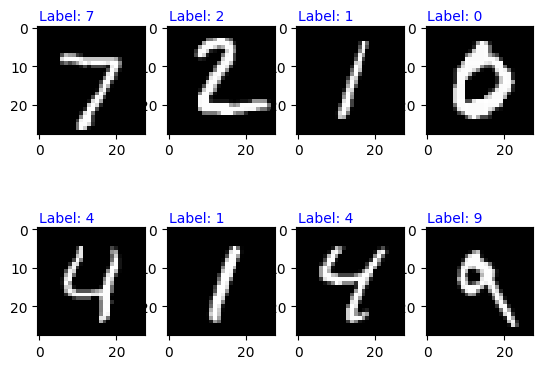

In [3]:
for i in range(8):  
    pyplot.subplot(240 + 1 + i)
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))
    pyplot.text(0, -2, f'Label: {y_test[i]}', color='blue')
pyplot.show()

### Preprocessing for Digit Recognition

preprocessing steps for digit recognition using deep learning.
Discover these crucial steps for optimizing model training.


In [4]:
# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

## Algorithem Implementation

#### Neural Network Activation Functions
This code segment presents two essential activation functions commonly used in neural networks:

1. **Sigmoid Activation (`Sigmoid` class)**:
   - `__call__`: Computes sigmoid of input `x`.
   - `gradient`: Calculates gradient \( \sigma(x) \cdot (1 - \sigma(x)) \).
2. **Softmax Activation (`Softmax` class)**:
   - `__call__`: Applies softmax to input vector.
   - `gradient`: Computes softmax gradient.

These functions empower neural networks to capture intricate patterns and produce accurate classifications.


In [5]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))
    

class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        p = self.__call__(x)
        return p * (1 - p)

#### Cross-Entropy Loss & Metrics

This code defines the `CrossEntropy` class, crucial for:

1. **Loss Calculation (`loss` method)**:
   - Computes cross-entropy loss with value clipping.
   - Formula: \( - y \log(p) - (1 - y) \log(1 - p) \).
2. **Accuracy Evaluation (`acc` method)**:
   - Measures classification accuracy using `accuracy_score`.
3. **Gradient Computation (`gradient` method)**:
   - Computes loss gradient with value clipping.
4. **Average Loss (`forward` method)**:
   - Calculates average cross-entropy loss.

These functions enhance precise loss assessment and model evaluation in classification tasks.


In [6]:
class CrossEntropy():
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)
        
    def forward(self, y_true, y_pred):
        # Avoid numerical instability by clipping predicted values
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

        # Calculate cross-entropy loss
        loss = - np.sum(y_true * np.log(y_pred))
        
        # Calculate the average loss
        avg_loss = loss / len(y_true)  
        
        return avg_loss

#### Multilayer Perceptron for Classification

This code snippet implements a classification-oriented Multilayer Perceptron (MLP):

- **Initialization**: Specifies hidden units, iterations, and learning rate.
- **Weight Initialization**: Sets initial weights for layers.
- **Training**: Conducts forward-backward passes, updating weights via gradients.
- **Prediction**: Computes class probabilities using trained weights.

This MLP empowers accurate classification by iteratively refining weight parameters.


In [7]:
class MultilayerPerceptron():

    def __init__(self, n_hidden, n_iterations=400, learning_rate=0.01):
        self.n_hidden = n_hidden
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.hidden_activation = Sigmoid()
        self.output_activation = Softmax()
        self.loss = CrossEntropy()

    def _initialize_weights(self, X, y):
        
        n_samples, n_features = X.shape
        _, n_outputs = y.shape
        
        # Hidden layer
        limit   = 1 / math.sqrt(n_features)
        self.W  = np.random.uniform(-limit, limit, (n_features, self.n_hidden))
        self.w0 = np.zeros((1, self.n_hidden))
        
        # Output layer
        limit   = 1 / math.sqrt(self.n_hidden)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden, n_outputs))
        self.v0 = np.zeros((1, n_outputs))


    def fit(self, X, y):

        self._initialize_weights(X, y)

        for i in range(self.n_iterations):

            # ..............
            #  Forward Pass
            # ..............

            # HIDDEN LAYER
            hidden_input = X.dot(self.W) + self.w0
            hidden_output = self.hidden_activation(hidden_input)
            # OUTPUT LAYER
            output_layer_input = hidden_output.dot(self.V) + self.v0
            y_pred = self.output_activation(output_layer_input)
            
            ############################################################

            # ...............
            #  Backward Pass
            # ...............

            # OUTPUT LAYER
            # Grad. with respect to input of output layer
            grad_wrt_out_l_input = self.loss.gradient(y, y_pred) * self.output_activation.gradient(output_layer_input)
            grad_v = hidden_output.T.dot(grad_wrt_out_l_input)
            grad_v0 = np.sum(grad_wrt_out_l_input, axis=0, keepdims=True)
            
            # HIDDEN LAYER
            # Grad. with respect to input of hidden layer
            grad_wrt_hidden_l_input = grad_wrt_out_l_input.dot(self.V.T) * self.hidden_activation.gradient(hidden_input)
            grad_w = X.T.dot(grad_wrt_hidden_l_input)
            grad_w0 = np.sum(grad_wrt_hidden_l_input, axis=0, keepdims=True)
            
            ############################################################

            # Update weights (by gradient descent)
            # Move against the gradient to minimize loss
            self.V  -= self.learning_rate * grad_v
            self.v0 -= self.learning_rate * grad_v0
            self.W  -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            
        self.loss_value = self.loss.forward(y, y_pred)
        self.acc_value = self.loss.acc(y, y_pred)

            
    def predict(self, X):
        hidden_input = X.dot(self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        output_layer_input = hidden_output.dot(self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)
        
        return y_pred

#### MLP Classification and Evaluation
This code snippet showcases the process of MLP classification and evaluation.

In [8]:
clf = MultilayerPerceptron(n_hidden=16, n_iterations=400, learning_rate=0.004)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = clf.loss.acc(y_test, y_pred)
print("loss:          ", clf.loss_value)
print("Train Accuracy:", clf.acc_value)
print("Test Accuracy: ", accuracy)


loss:           0.014906756931354848
Train Accuracy: 0.999
Test Accuracy:  0.92


#### confusion matrix

<Figure size 1000x1000 with 0 Axes>

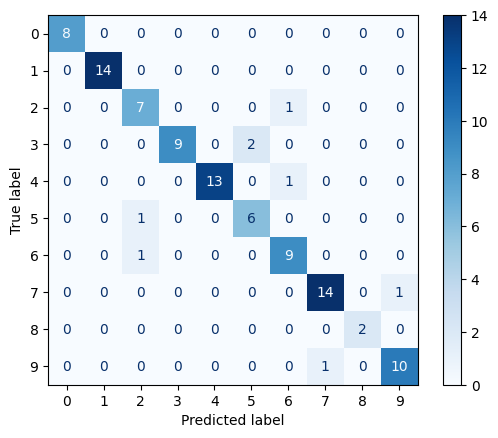

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert y_pred to class labels using threshold as before
threshold = 0.5
y_pred_labels = np.argmax(y_pred, axis=1)

# Make sure y_test is converted to the correct data type
y_test_array = np.array(y_test)

# If data type is "multilabel-indicator", convert to "multiclass" type
if y_test_array.ndim > 1 and y_test_array.shape[1] > 1:
    y_test_array = np.argmax(y_test_array, axis=1)

# Calculate the matrix of errors
cm = confusion_matrix(y_test_array, y_pred_labels)

# Display the matrix of errors
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()
